# COMP4318/5318 Assignment 2: Image Classification

### Group number: 283  , SID1: 540282735 , SID2: 540114883

This template notebook includes code to load the  dataset and a skeleton for the main sections that should be included in the notebook. Please stick to this struture for your submitted notebook.

Please focus on making your code clear, with appropriate variable names and whitespace. Include comments and markdown text to aid the readability of your code where relevant. See the specification and marking criteria in the associated specification to guide you when completing your implementation.

## Setup and dependencies
Please use this section to list and set up all your required libraries/dependencies and your plotting environment. 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedGroupKFold, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


import keras_tuner
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import ParameterGrid
import pandas as pd
import time

## 1. Data loading, exploration, and preprocessing


Code to load the dataset is provided in the following cell. Please proceed with your data exploration and preprocessing in the remainder of this section.

In [4]:
# Load the dataset training and test sets as numpy arrays
# assuming Assignment2Data folder is present in the same directory 
# as the notebook
X_train = np.load('Assignment2Data/X_train.npy')
y_train = np.load('Assignment2Data/y_train.npy')
X_test = np.load('Assignment2Data/X_test.npy')
y_test = np.load('Assignment2Data/y_test.npy')


In [5]:
print(X_train.shape)

(32000, 28, 28, 3)


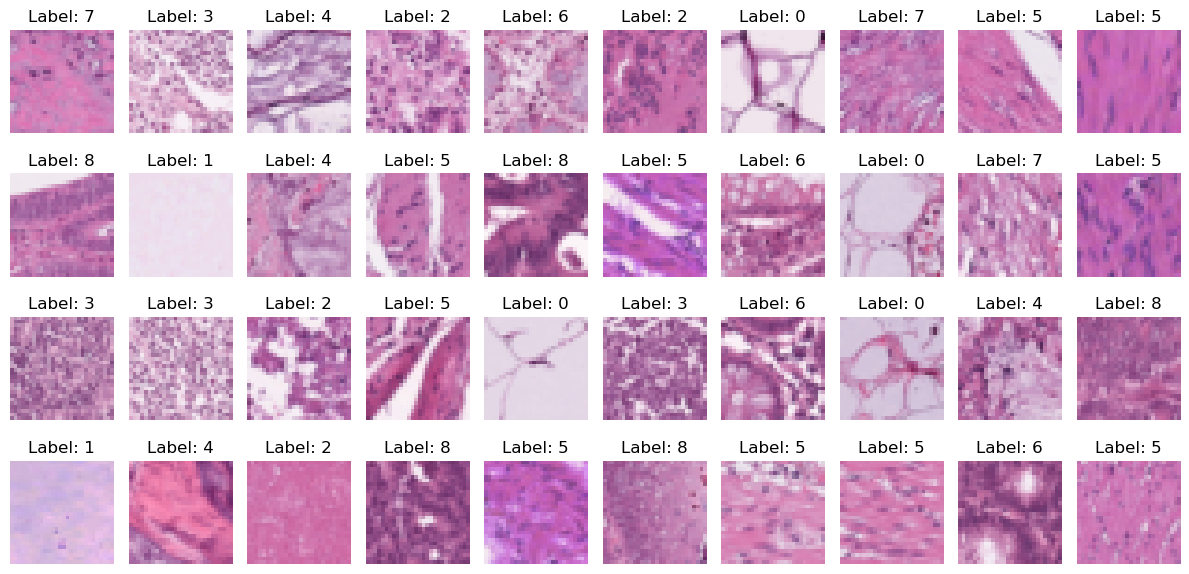

In [6]:

def plot_examples(data, label, num_rows=4, num_cols=10):
    plt.figure(figsize=(num_cols * 1.2, num_rows * 1.5))
    for row in range(num_rows):
        for col in range(num_cols):
            index = num_cols * row + col
            plt.subplot(num_rows, num_cols, index + 1)
            plt.imshow(data[index])
            plt.title(f"Label: {label[index]}")
            plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_examples(X_train, y_train)

In [7]:

print(np.min(X_train), np.max(X_train))

0 255


In [8]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1)).reshape(X_train.shape) 
X_test_scaled = scaler.transform(X_test.reshape(X_test.shape[0], -1)).reshape(X_test.shape)

In [9]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [10]:
print(X_train_flat.shape)

(32000, 2352)


In [11]:
pca = PCA()
pca.fit(X_train_flat)
cumsum = np.cumsum(pca.explained_variance_ratio_)


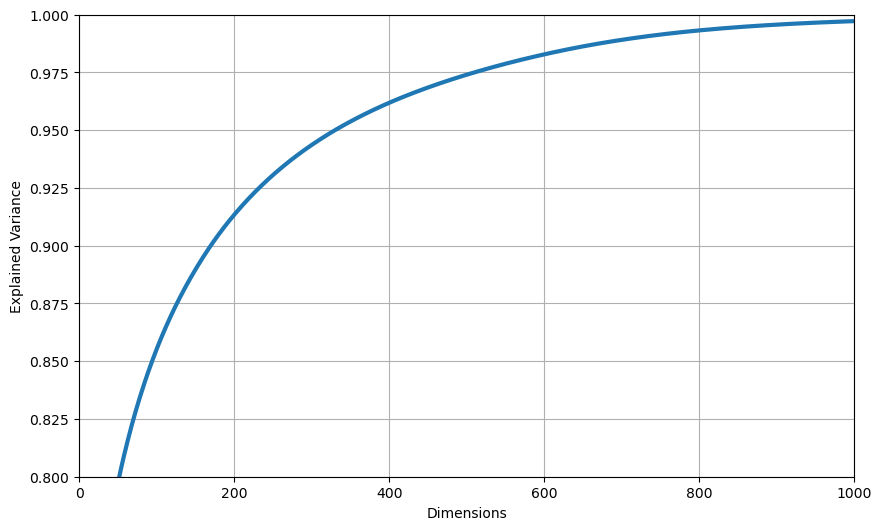

In [12]:

plt.figure(figsize=(10, 6))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 1000, 0.8, 1])  
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.grid(True)
plt.show()


In [13]:
print("Number of components to retain 95% variance: ", np.argmax(cumsum >= 0.95) + 1)
print("Number of components to retain 98% variance: ", np.argmax(cumsum >= 0.98) + 1)
print("Number of components to retain 99% variance: ", np.argmax(cumsum >= 0.99) + 1)

Number of components to retain 95% variance:  332
Number of components to retain 98% variance:  566
Number of components to retain 99% variance:  719


In [14]:
pca = PCA(n_components=719) 
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)

In [15]:
print(X_train_pca.shape)

(32000, 719)


### Examples of preprocessed data
Please print/display some examples of your preprocessed data here.

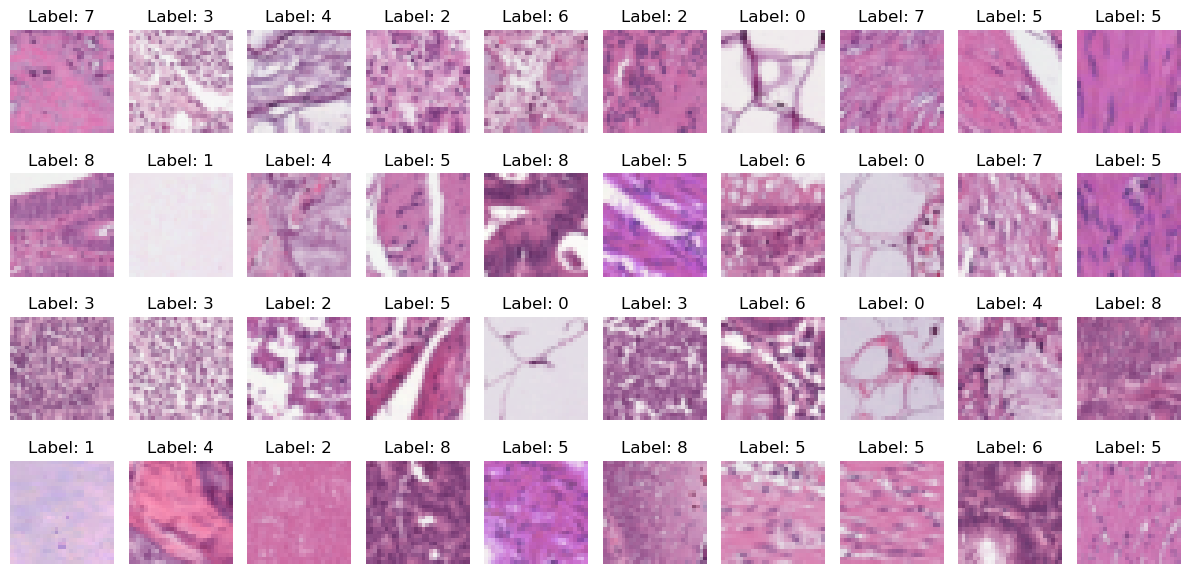

In [16]:
plot_examples(X_train_scaled, y_train)

In [17]:
print(X_train.shape)
print(X_test_pca.shape)
print(X_train[0])

(32000, 28, 28, 3)
(8000, 719)
[[[199 129 181]
  [191 127 174]
  [179 118 173]
  ...
  [209 136 184]
  [209 118 178]
  [205 122 180]]

 [[202 125 181]
  [194 127 182]
  [184 117 174]
  ...
  [194 137 182]
  [162  95 154]
  [156  89 150]]

 [[165 102 156]
  [182 108 167]
  [190 115 174]
  ...
  [202 138 188]
  [181 125 178]
  [163 102 159]]

 ...

 [[208 124 182]
  [206 128 184]
  [217 123 181]
  ...
  [217 128 185]
  [212 135 189]
  [207 137 190]]

 [[203 123 180]
  [194 127 182]
  [204 125 182]
  ...
  [207 135 187]
  [205 137 190]
  [204 132 187]]

 [[202 122 180]
  [189 126 180]
  [184 122 176]
  ...
  [202 123 181]
  [191 124 181]
  [190 117 176]]]


In [18]:
print(np.unique(y_train))

[0 1 2 3 4 5 6 7 8]


## 2. Algorithm design and setup

### Algorithm of choice from first six weeks of course

In [19]:
def bulid_svm(param):
    model = SVC(**param)
    return model

### Fully connected neural network

In [20]:
def build_mlp(hp):
    model = keras.Sequential([
        keras.layers.Input(shape=(X_train_pca.shape[1],)),
        keras.layers.Dense(units=hp.Int('units_1', min_value=128, max_value=1024, step=64), activation='relu'),  # Updated range
        keras.layers.Dense(units=hp.Int('units_2', min_value=64, max_value=512, step=32), activation='relu'),  # Updated range
        keras.layers.Dense(9, activation='softmax')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[5e-4, 1e-3, 5e-3])),  # Updated values
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

### Convolutional neural network

In [21]:
def build_cnn(hp):
    model = keras.Sequential([
        keras.layers.Input((28, 28, 3)),
        keras.layers.Conv2D(filters=hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),  
                            kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
                            activation='relu', padding='same'),
        keras.layers.MaxPooling2D(pool_size=2),
        keras.layers.Conv2D(filters=hp.Int('conv_2_filters', min_value=64, max_value=256, step=64),  
                            kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),  
                            activation='relu', padding='same'),
        keras.layers.MaxPooling2D(pool_size=2),
        keras.layers.Flatten(),
        keras.layers.Dense(units=hp.Int('dense_units', min_value=128, max_value=1024, step=128), activation='relu'),  
        keras.layers.Dense(9, activation='softmax')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[5e-4, 1e-3, 5e-3])),  
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'] 
    )
    
    return model

## 3. Hyperparameter tuning

In [22]:
X_small, _, y_small, _ = train_test_split(
    X_train_pca, y_train,
    train_size=6000,
    stratify=y_train,
    random_state=42
)


X_train_val, X_val, y_train_val, y_val = train_test_split(
    X_small, y_small,
    test_size=0.2,
    stratify=y_small,
    random_state=42
)

### Algorithm of choice from first six weeks of course

In [23]:
svm_param_grid = {
    'C': [1, 10],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'gamma': ['scale']
}

svm_search = RandomizedSearchCV(
    estimator=SVC(),
    param_distributions=svm_param_grid,
    n_iter=5,
    cv=3,
    n_jobs=-1,
    verbose=2
)

svm_search.fit(X_train_val, y_train_val)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ..................C=10, gamma=scale, kernel=sigmoid; total time=   6.0s
[CV] END ..................C=10, gamma=scale, kernel=sigmoid; total time=   6.1s
[CV] END ..................C=10, gamma=scale, kernel=sigmoid; total time=   6.0s
[CV] END ...................C=10, gamma=scale, kernel=linear; total time=   7.6s
[CV] END ...................C=10, gamma=scale, kernel=linear; total time=   7.6s
[CV] END ...................C=10, gamma=scale, kernel=linear; total time=   7.8s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   9.5s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   9.6s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   7.5s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   7.6s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   8.3s
[CV] END ....................C=1, gamma=scale, ke

RandomizedSearchCV(cv=3, estimator=SVC(), n_iter=5, n_jobs=-1,
                   param_distributions={'C': [1, 10], 'gamma': ['scale'],
                                        'kernel': ['rbf', 'linear', 'poly',
                                                   'sigmoid']},
                   verbose=2)

In [24]:
results_df = pd.DataFrame(svm_search.cv_results_)

results_df = results_df[[
    'params',
    'mean_test_score',
    'std_test_score',
    'rank_test_score'
]]


results_df = results_df.sort_values(by='mean_test_score', ascending=False)

print(results_df)
print("Best parameters: ", svm_search.best_params_)
results_df.to_csv("svm_search_results.csv", index=False)

                                             params  mean_test_score  \
3       {'kernel': 'rbf', 'gamma': 'scale', 'C': 1}         0.591875   
2      {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}         0.578542   
1   {'kernel': 'linear', 'gamma': 'scale', 'C': 10}         0.381250   
4    {'kernel': 'linear', 'gamma': 'scale', 'C': 1}         0.381250   
0  {'kernel': 'sigmoid', 'gamma': 'scale', 'C': 10}         0.282708   

   std_test_score  rank_test_score  
3        0.010206                1  
2        0.010223                2  
1        0.010607                3  
4        0.010607                3  
0        0.035858                5  
Best parameters:  {'kernel': 'rbf', 'gamma': 'scale', 'C': 1}


### Fully connected neural network

In [25]:
mlp_tuner = keras_tuner.RandomSearch(
    hypermodel=build_mlp,
    objective="val_accuracy", 
    max_trials=10,  # Increased trials
    executions_per_trial=3,  # Increased executions  
    overwrite=True,
    directory="result", 
    project_name="mlp"  
)

mlp_tuner.search(X_train_val, y_train_val, epochs=30, validation_data=(X_val, y_val))

Trial 10 Complete [00h 00m 33s]
val_accuracy: 0.42249999443689984

Best val_accuracy So Far: 0.5099999904632568
Total elapsed time: 00h 04m 16s


In [26]:
print("Best MLP parameters:", mlp_tuner.get_best_hyperparameters()[0].values)

trials = list(mlp_tuner.oracle.trials.values())

results = [{
    **trial.hyperparameters.values,
    "val_accuracy": trial.metrics.get_last_value("val_accuracy"),
    "score": trial.score
} for trial in trials]


results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="val_accuracy", ascending=False)

print(results_df)


Best MLP parameters: {'units_1': 448, 'units_2': 480, 'learning_rate': 0.0005}
   units_1  units_2  learning_rate  val_accuracy     score
7      448      480         0.0005      0.510000  0.510000
2      320      352         0.0010      0.506111  0.506111
4      256      320         0.0010      0.496944  0.496944
8      960      416         0.0010      0.495833  0.495833
3      128      256         0.0010      0.485000  0.485000
0      128      192         0.0005      0.461111  0.461111
1      192       96         0.0005      0.454722  0.454722
5      704      320         0.0050      0.435833  0.435833
9      640      512         0.0050      0.422500  0.422500
6     1024      288         0.0050      0.367222  0.367222


### Convolutional neural network

In [27]:
cnn_tuner = keras_tuner.RandomSearch(
    hypermodel=build_cnn,
    objective='val_accuracy', 
    max_trials=10,
    executions_per_trial=3,
    overwrite=True,
    directory="result", 
    project_name="cnn" 
)

In [28]:
X_tune, _, y_tune, _ = train_test_split(X_train_scaled, y_train, train_size=6000, stratify=y_train, random_state=42)

cnn_tuner.search(X_tune, y_tune, epochs=30, validation_split=0.2)


Trial 10 Complete [00h 22m 15s]
val_accuracy: 0.7322222391764323

Best val_accuracy So Far: 0.7463888923327128
Total elapsed time: 02h 23m 30s


In [29]:
print("Best CNN parameters:", cnn_tuner.get_best_hyperparameters()[0].values)

cnn_trials = list(cnn_tuner.oracle.trials.values())


cnn_results = [{
    **trial.hyperparameters.values,
    "val_accuracy": trial.metrics.get_last_value("val_accuracy"),
    "score": trial.score
} for trial in cnn_trials]


cnn_results_df = pd.DataFrame(cnn_results)
cnn_results_df = cnn_results_df.sort_values(by="val_accuracy", ascending=False)

print(cnn_results_df)


Best CNN parameters: {'conv_1_filters': 32, 'conv_1_kernel': 3, 'conv_2_filters': 128, 'conv_2_kernel': 3, 'dense_units': 768, 'learning_rate': 0.0005}
   conv_1_filters  conv_1_kernel  conv_2_filters  conv_2_kernel  dense_units  \
6              32              3             128              3          768   
8             128              3              64              3          640   
0              32              3             192              3          256   
9             128              3             128              3          256   
2              32              3              64              5          768   
3              32              5              64              3          640   
1              96              5              64              5          256   
7              64              5              64              3          128   
4              64              5             256              3          512   
5              32              5             256

## 4. Final models
In this section, please ensure to include cells to train each model with its best hyperparmater combination independently of the hyperparameter tuning cells, i.e. don't rely on the hyperparameter tuning cells having been run.

### Algorithm of choice from first six weeks of course

In [30]:
# the best parameters
best_svm = SVC(kernel='rbf', C=1, gamma='scale')

# train
start_time = time.time()
best_svm.fit(X_train_pca, y_train)
svm_train_time = time.time() - start_time
print(f"SVM training time: {svm_train_time:.2f} seconds")

svm_accuracy = best_svm.score(X_test_pca, y_test)
print(f"Best SVM Test Accuracy: {svm_accuracy:.3f}")

SVM training time: 237.36 seconds
Best SVM Test Accuracy: 0.659


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.89       873
           1       0.96      0.88      0.91       858
           2       0.47      0.30      0.36       877
           3       0.91      0.85      0.88       914
           4       0.58      0.58      0.58       737
           5       0.64      0.68      0.66      1072
           6       0.44      0.26      0.32       682
           7       0.48      0.52      0.50       813
           8       0.55      0.77      0.64      1174

    accuracy                           0.66      8000
   macro avg       0.65      0.64      0.64      8000
weighted avg       0.65      0.66      0.65      8000



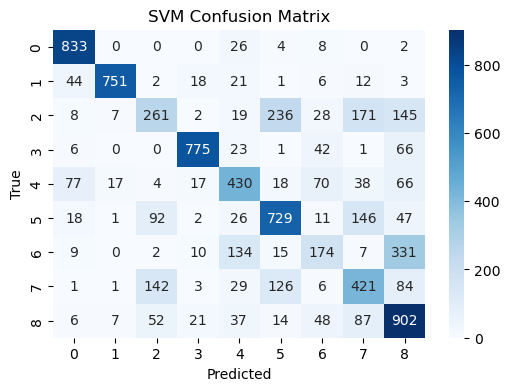

In [31]:
y_pred_svm = best_svm.predict(X_test_pca)

print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Blues')
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### Fully connected neural network

In [32]:
# best parameter: units_1=576, units_2=448, learning_rate=0.001
mlp = keras.Sequential([
    keras.layers.Input(shape=(X_train_pca.shape[1],)),
    keras.layers.Dense(576, activation='relu'),
    keras.layers.Dense(448, activation='relu'),
    keras.layers.Dense(9, activation='softmax')
])

mlp.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])


start_time = time.time()
mlp.fit(X_train_pca, y_train, epochs=100, batch_size=64)
mlp_train_time = time.time() - start_time
print(f"MLP training time: {mlp_train_time:.2f} seconds")

_, mlp_accuracy = mlp.evaluate(X_test_pca, y_test)
print(f"Best MLP Test Accuracy: {mlp_accuracy:.3f}")

Epoch 1/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4111 - loss: 14.5633
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6173 - loss: 1.0120
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7014 - loss: 0.8001
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7591 - loss: 0.6459
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7959 - loss: 0.5663
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8141 - loss: 0.5157
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8226 - loss: 0.5021
Epoch 8/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8356 - loss: 0.4823
Epoch 9/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8468 - loss: 0.4596
Epoch 10/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8588 - loss: 0.4093
Epoch 11/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8611 - loss: 0.4113
Epoch 12/100
500/500 ━━━━━━━━━━━━━━━━━━━

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step
MLP Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.90      0.86       873
           1       0.92      0.90      0.91       858
           2       0.42      0.39      0.40       877
           3       0.82      0.75      0.78       914
           4       0.49      0.48      0.48       737
           5       0.59      0.60      0.59      1072
           6       0.31      0.42      0.36       682
           7       0.41      0.38      0.39       813
           8       0.56      0.51      0.53      1174

    accuracy                           0.60      8000
   macro avg       0.59      0.59      0.59      8000
weighted avg       0.60      0.60      0.60      8000



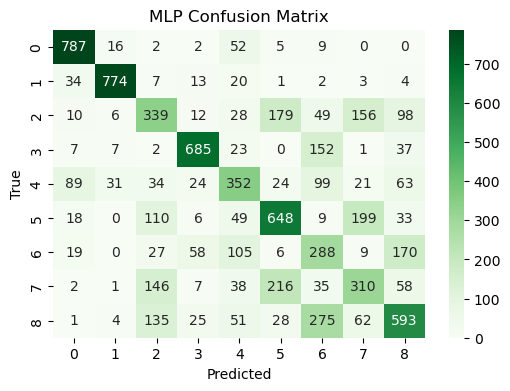

In [33]:
y_pred_mlp = mlp.predict(X_test_pca)
y_pred_labels_mlp = y_pred_mlp.argmax(axis=1)

print("MLP Classification Report:")
print(classification_report(y_test, y_pred_labels_mlp))


plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_labels_mlp), annot=True, fmt='d', cmap='Greens')
plt.title("MLP Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### Convolutional neural network

In [34]:
# best parameter: {'conv_1_filters': 96, 'conv_1_kernel': 3, 'conv_2_filters': 64, 'conv_2_kernel': 3, 'dense_units': 640, 'learning_rate': 0.0005}
cnn = keras.Sequential([
    keras.layers.Input(shape=(28, 28, 3)),
    keras.layers.Conv2D(96, kernel_size=3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(640, activation='relu'),
    keras.layers.Dense(9, activation='softmax')
])

cnn.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])


start_time = time.time()
cnn.fit(X_train_scaled, y_train, epochs=100, batch_size=64)
cnn_train_time = time.time() - start_time
print(f"CNN training time: {cnn_train_time:.2f} seconds")


_, cnn_accuracy = cnn.evaluate(X_test_scaled, y_test)
print(f"Best CNN Test Accuracy: {cnn_accuracy:.3f}")

Epoch 1/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.3873 - loss: 1.6017
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - accuracy: 0.6598 - loss: 0.9202
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.7303 - loss: 0.7413
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.7662 - loss: 0.6451
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.7886 - loss: 0.5802
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.8110 - loss: 0.5272
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.8186 - loss: 0.4969
Epoch 8/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.8322 - loss: 0.4633
Epoch 9/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.8469 - loss: 0.4202
Epoch 10/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.8487 - loss: 0.4152
Epoch 11/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.8632 - loss: 0.3808
Epoch 12/100
500/50

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
CNN Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       873
           1       0.98      0.97      0.98       858
           2       0.81      0.71      0.76       877
           3       0.95      0.96      0.95       914
           4       0.83      0.87      0.85       737
           5       0.83      0.84      0.83      1072
           6       0.80      0.79      0.80       682
           7       0.67      0.68      0.67       813
           8       0.86      0.88      0.87      1174

    accuracy                           0.86      8000
   macro avg       0.85      0.85      0.85      8000
weighted avg       0.86      0.86      0.86      8000



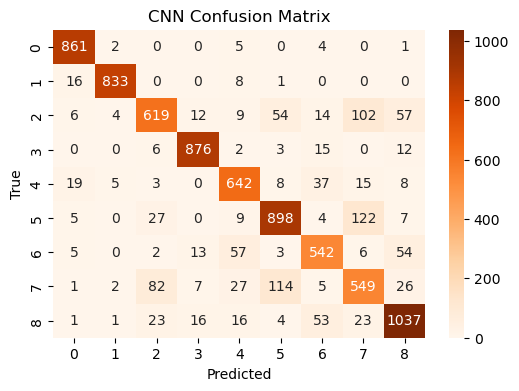

In [35]:
y_pred_cnn = cnn.predict(X_test_scaled)
y_pred_labels_cnn = y_pred_cnn.argmax(axis=1)


print("CNN Classification Report:")
print(classification_report(y_test, y_pred_labels_cnn))


plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_labels_cnn), annot=True, fmt='d', cmap='Oranges')
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()